# Project : Machine Learning for Robotics
---
Group L 

GOMEZ Louis  
MEKHZOUNI Romaïssa  
PINEAU FERRAND Emeline  
SURESH Sini

--- 


#Realtime Multi-Person 2D Pose Estimation using Part Affinity Fields

This notebook is exploring the algorithm for human pose estimation OpenPose. The original repository is in https://github.com/CMU-Perceptual-Computing-Lab/openpose and the pytorch implementation used here comes from  https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation

## Introduction

The estimation of human posture is the process of modeling the human body as a set of some parts (e.g., arms, legs, torso, etc.) and finding their positions in an image. Several studies have been developed in order to generate these estimates in real time using various techniques of Deep Learning. In this Notebook we study the development done in [[1]](https://ieeexplore.ieee.org/document/8099626), which makes use of Part Affinity Fields for this purpose.

Inferring the pose of multiple people in images, especially socially engaged individuals, presents a unique set of challenges. First, each image may contain an unknown number of people that can occur at any position or scale. Second, interactions between people induce complex spatial interference, due to contact, occlusion, and limb articulations, making association of parts difficult. Third, runtime complexity tends to grow with the number of people in the image, making realtime performance a challenge. The Caffe implementation (C++ with a python interface) is in https://github.com/CMU-Perceptual-Computing-Lab/openpose 

In [[1]](https://ieeexplore.ieee.org/document/8099626), a method for estimating the posture of various persons at multiple public reference points is presented. It uses the ascending representation of association scores through the part affinity fields (PAF), a set of 2D vector fields that encode the location and orientation of the limbs over the image domain. These bottom-up representations of detection and association are simultaneously inferred and encode the global context of the scene.

We will exploit a PyTorch implementation. If you wish a quick tutorial to PyTorch, you can look at https://pytorch.org/tutorials/beginner/nn_tutorial.html.

In [ ]:
# Libraries
# Colab libraries
from google.colab import drive
from google.colab import output
drive.mount('/content/gdrive')
colab_path = "/content/gdrive/My Drive/Colab Notebooks/"

# Basis libraries
import os, re, sys, math, time, scipy, argparse
import cv2, matplotlib
import matplotlib.gridspec as gridspec
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from scipy.ndimage.morphology import generate_binary_structure
from scipy.ndimage.filters import gaussian_filter, maximum_filter

Mounted at /content/gdrive


## Settings

First, we install the necessary packages

In [ ]:
# Independence install
!sudo apt-get install swig


# Repository compile
# %cd "RT-multiperson-pose-pytorch"
%cd $colab_path"/Projet_RL_Robotics/RT-multiperson-pose-pytorch"
%cd lib/pafprocess 
!sh make.sh

# Libraries install
%cd $colab_path"/Projet_RL_Robotics/RT-multiperson-pose-pytorch"
!python -m pip install -r ./requirements.txt
!pip3 install numpngw

print("[INFO]: Project requirements installed successfully")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,473 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fr

Now, we can import others libraries use in the project, contained in the repository.

In [ ]:
# Framework libraries
# %cd $colab_path"RT-multiperson-pose-pytorch"
%cd $colab_path"Projet_RL_Robotics/RT-multiperson-pose-pytorch"
sys.path.append('.'); sys.argv=['']
from lib.network.rtpose_vgg import get_model 
from lib.network import im_transform
from evaluate.coco_eval import get_outputs, handle_paf_and_heat
from lib.utils.common import Human, BodyPart, CocoPart, CocoColors, CocoPairsRender, draw_humans
from lib.utils.paf_to_pose import paf_to_pose_cpp
from lib.config import cfg, update_config
from torchsummary import summary
from evaluate.coco_eval import get_outputs, handle_paf_and_heat, run_eval

/content/gdrive/My Drive/Colab Notebooks/Projet_RL_Robotics/RT-multiperson-pose-pytorch


And update the variables space.

In [ ]:
###########NETWORK CONFIG ############
class Namespace:
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

# update config file
args = Namespace(cfg = './experiments/vgg19_368x368_sgd.yaml', weight = 'pose_model.pth', opts = [])
update_config(cfg, args)

## **Network understanding**

In general terms, the method developed for the Multi-Person 2D Pose Estimation is divided into several stages. In the figure, the general architecture of the system is shown. 

First, the system takes, as input, a $wxh$ size colour image,  the image is  analyzed by a convolutional network (initialized by the first 10 layers of VGG-19  and finetuned), generating a set of feature maps that is input to the first stage of 2 branchs. The two brach correspond to the parts of a feedforward network that simultaneously predicts, first a 2D confidence set $S = (S_{1},S_{2},...,S_{J})$ maps of the locations of the body parts $J$ one per location  (RKnee,Shoulder,Hip, etc) where 
$S_{j}\in \mathbb{R}^{wxh}, j \in {1,...,J}$; 
and a set of 2D vector fields of the affinities of the parts 
$L = (L_{1},L_{2},...,L_{C})$ , which encode the degree of association between the parts ,it has $C$ vector fields, one per limb( pairs of body parts ), where
 $L_{c}\in \mathbb{R}^{wxhx2},c \in {1,...,C}$


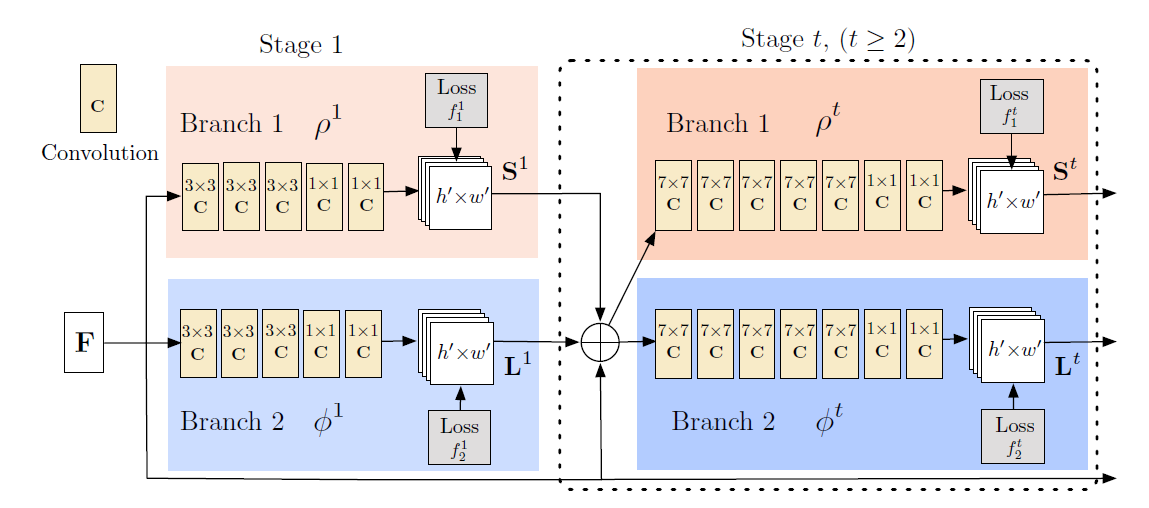

Next we will use the code picture_demo.py in order to explain the composition of the network, and the processes that are made in order to obtain the estimation of poses, considering that it is already trained

### ***Model extraction***

Initially, the input dimension image () is introduced into the first 10 layers of the CNN VGG-19 model, which is normally used for image classification, and produces a set of feature maps F that is input to the first stage of each branch.

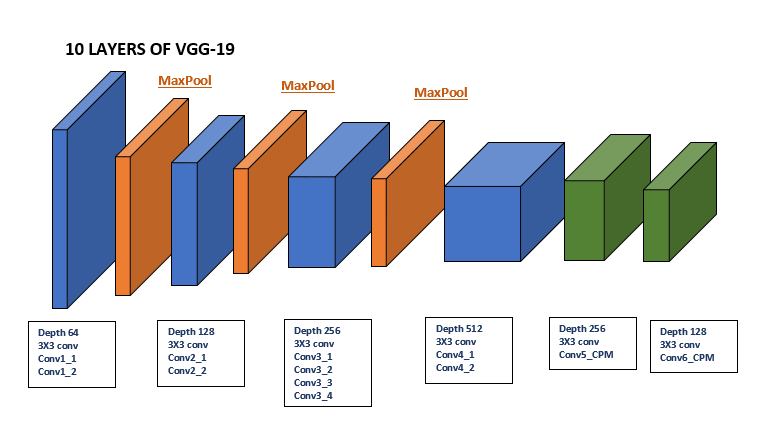

In order to make the prediction of the confidence maps (**S**) and the vector fields of the affinity of the parts PAFs (**L**) two brachs were designed, which are composed of 6 stages, however the process of optimization and execution is done in parallel. 

At the first stage, the network produces a set of detection confidence maps $S_{1} = \rho^{1} (F)$ and a set of part affinity fields $L_{1} = \phi^{1}(F)$, where $\rho^{1}$ and $\phi^{1}$ are the CNNs for inference at Stage 1. In each subsequent stage, the predictions from both branches in the previous stage,along with the original image features $F$, are concatenated and used to produce refined predictions, in other words a recurrent neuronal network (RNN).

$$S^{t} = \rho ^{t}(F,S^{t-1},L^{t-1}),\forall t \geq 2 $$

$$L^{t} = \phi ^{t}(F,S^{t-1},L^{t-1}),\forall t \geq 2 $$


The following figures present in more detail each subnetwork

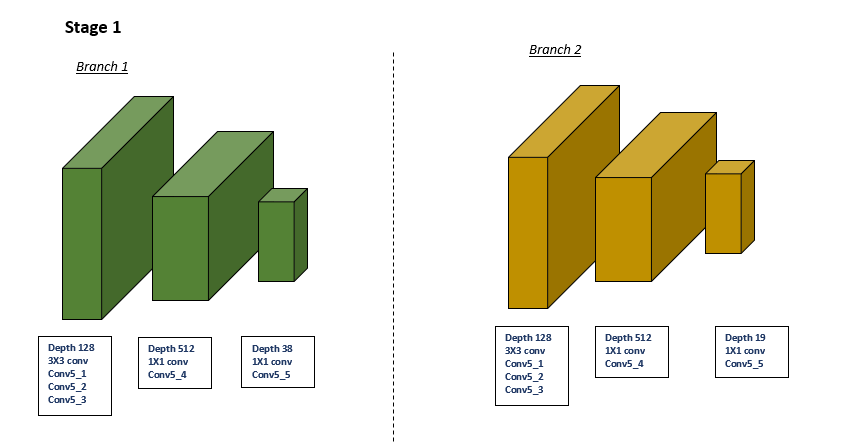

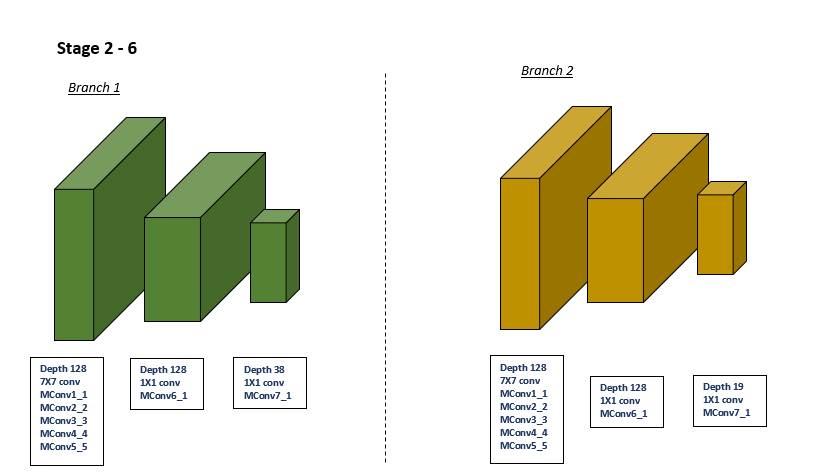

The refinement of the confidence maps and affinity fields is made across stages. To guide the network to iteratively predict confidence maps of body parts in the first branch and PAFs in the second branch, it is applied two loss
functions at the end of each stage, one at each branch respectively.

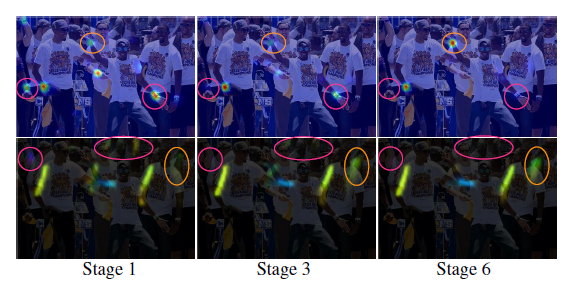

In the following code fragment you can see the detail of the network

In [ ]:
model = get_model('vgg19')   
model.load_state_dict(torch.load(args.weight))
model = torch.nn.DataParallel(model).cuda()
model.float()
model.eval()

Bulding VGG19
Done !


DataParallel(
  (module): rtpose_model(
    (model0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

### ***Test image***

Then we will proceed to test the performance of the network with a test image. In the following code the image to be tested is presented

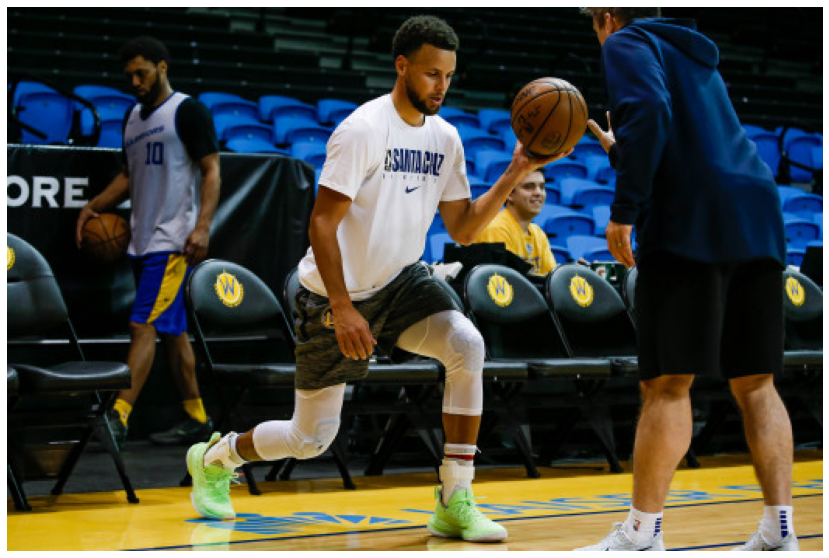

In [ ]:
test_image = './readme/curry.jpg'
oriImg = cv2.imread(test_image) # B,G,R order
shape_dst = np.min(oriImg.shape[0:2])
destRGB = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,10))
imgplot = plt.imshow(destRGB)
plt.axis('off')
plt.show()

You can also test on other images in the folder or upload your image

In [ ]:
!pwd
!ls ./readme/

/content/gdrive/My Drive/Colab Notebooks/Projet_RL_Robotics/RT-multiperson-pose-pytorch
cara.jpg  curry.jpg  muchas.jpg  pose.png  ski.jpg  training_structure.png


#### ***Confidence Maps for Part Detection and Part Affinity Fields for Part Association***

This section will show the different steps that the network runs in order to determine the position of people

##### ***Maps for Part Detection***

Each confidence map is a 2D representation of the belief that a particular body part occurs at each pixel location. Ideally, if a single person occurs in the image, a single peak should exist in each confidence map if the corresponding part is visible; if multiple people occur, there should be a peak corresponding to each visible part j for each person k.

In [ ]:
# Get results of original image

with torch.no_grad():
    paf, heatmap, im_scale = get_outputs(oriImg, model,  'rtpose')
          
#print('Mean Average Precision: {}'.format(im_scale))

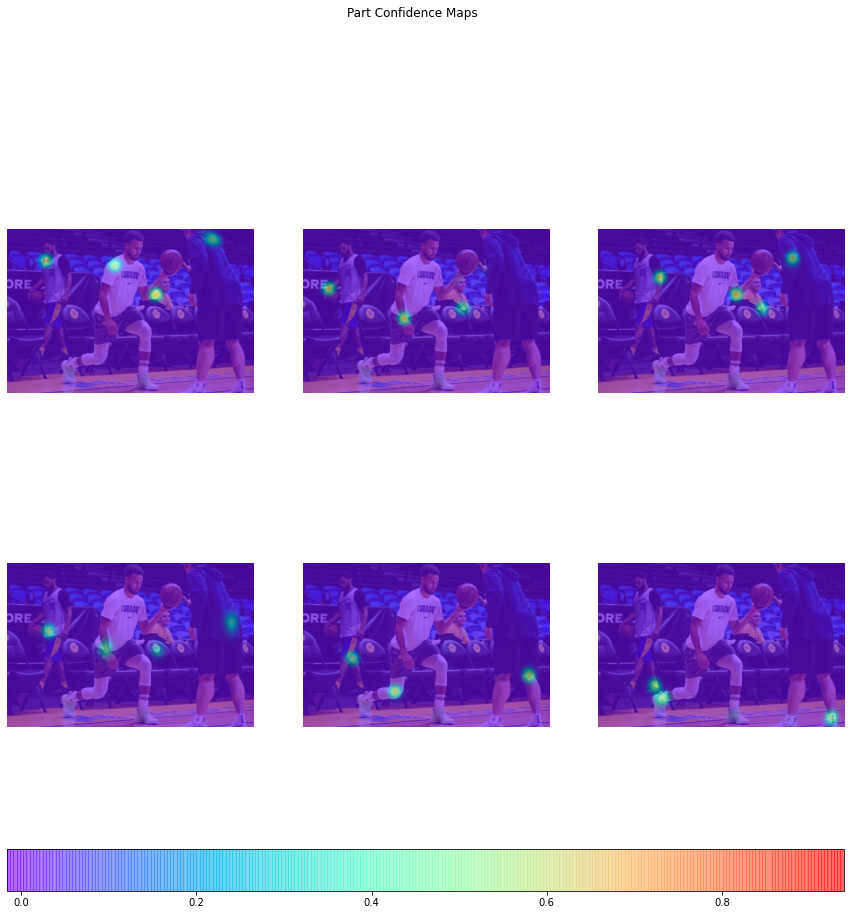

In [ ]:
# There is a heat map by area of the body found as shown below
# Nose = 0, Neck = 1, RShoulder = 2, RElbow = 3, RWrist = 4, LShoulder = 5, LElbow = 6, LWrist = 7
# RHip = 8, RKnee = 9, RAnkle = 10, LHip = 11, LKnee = 12, LAnkle = 13, REye = 14, LEye = 15, REar = 16, 
# LEar = 17,Background = 18

from matplotlib import colors
Nr = 2
Nc = 3
Grahp=[2,4,6,8,9,10]
cmap='rainbow'
interpolation='bicubic'
alpha=.6


img = plt.imread('./readme/curry.jpg')


fig, axs = plt.subplots(Nr, Nc,figsize=(15,15))
fig.suptitle('Part Confidence Maps')

images = []
aux =0

plt.imshow(img, alpha=1) # for image
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
for i in range(Nr):
    for j in range(Nc):
        # Generate data with a range that varies from one plot to the next.
        ImagMap=heatmap[:,:,Grahp[aux]]
        axs[i, j].imshow(img, alpha=1) 
        images.append(axs[i, j].imshow(ImagMap, cmap=cmap, interpolation=interpolation,alpha=alpha,extent=(xmin,xmax,ymin,ymax)))
        axs[i, j].label_outer()
        axs[i, j].grid(b=False)
        axs[i, j].axis('off')
        aux+=1

# Find the min and max of all colors for use in setting the color scale.
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)

fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.1)

plt.grid(b=False)
plt.axis('off')
plt.show()


#### Part Affinity Fields for Part Association
For each connection between the parts detected by the trusted potatoes, there are two layers that represent the affinity field of those connections. In other words, an affinity field shows the probable normalized direction of a pixel towards its corresponding connection pixel, and two coordinates ($x_{j_1,k}$ and $x_{j_2,k}$) for $k$-limb conection are needed to describe this direction. If we plot some part affinity fields in the original image, we can see the limb join field between two parts of the body, for each person. The following code show some part affinity fields in the original image:

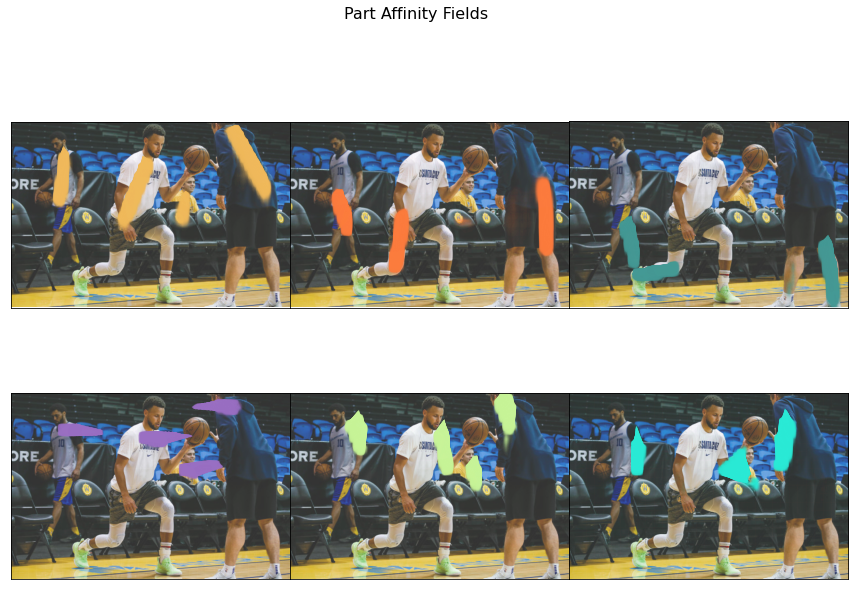

In [ ]:
# The order to swap left and right of heatmap
    #swap_heat = np.array((0, 1, 5, 6, 7, 2, 3, 4, 11, 12,
                        #  13, 8, 9, 10, 15, 14, 17, 16, 18))

    # paf's order
    # 0,1 2,3 4,5
    # neck to right_hip, right_hip to right_knee, right_knee to right_ankle

    # 6,7 8,9, 10,11
    # neck to left_hip, left_hip to left_knee, left_knee to left_ankle

    # 12,13 14,15, 16,17, 18, 19
    # neck to right_shoulder, right_shoulder to right_elbow, right_elbow to
    # right_wrist, right_shoulder to right_ear

    # 20,21 22,23, 24,25 26,27
    # neck to left_shoulder, left_shoulder to left_elbow, left_elbow to
    # left_wrist, left_shoulder to left_ear

    # 28,29, 30,31, 32,33, 34,35 36,37
    # neck to nose, nose to right_eye, nose to left_eye, right_eye to
    # right_ear, left_eye to left_ear So the swap of paf should be:
    #swap_paf = np.array((6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 20, 21, 22, 23,
                       #  24, 25, 26, 27, 12, 13, 14, 15, 16, 17, 18, 19, 28,
                        # 29, 32, 33, 30, 31, 36, 37, 34, 35))

    #flipped_paf = flipped_paf[:, ::-1, :]

out_paf = np.zeros([paf.shape[2], img.shape[0], img.shape[1]])

for h in range(paf.shape[2]):
  out_paf[h] = cv2.resize(paf[:,:,h], (img.shape[1], img.shape[0]))
X, Y = np.meshgrid(np.arange(0, img.shape[1], 1) , np.arange(0, img.shape[0], 1))

fig, axs = plt.subplots(nrows= 2, ncols = 3, figsize = (15,10), sharex=True, sharey=True)
paf_view = [0,1,2,10,11,12]
colors = np.random.randint(0, 255, size = (2*3,3), dtype = "uint8") / 255.0
for i,ax in enumerate(axs.flatten()):
  ax.imshow(img, alpha = 0.8)
  ax.quiver(X, Y, out_paf[2*paf_view[i]], out_paf[2*paf_view[i] + 1], 
            minlength=0, alpha = 0.5, color = colors[i])
  ax.set_xticklabels([]); ax.set_yticklabels([])
  ax.set_xticks([]); ax.set_yticks([]); ax.axis("on")

fig.subplots_adjust(wspace=0.0,hspace=0.0)
fig.suptitle("Part Affinity Fields", fontsize=16)
fig.show()

mAP: 1.0514285714285714 


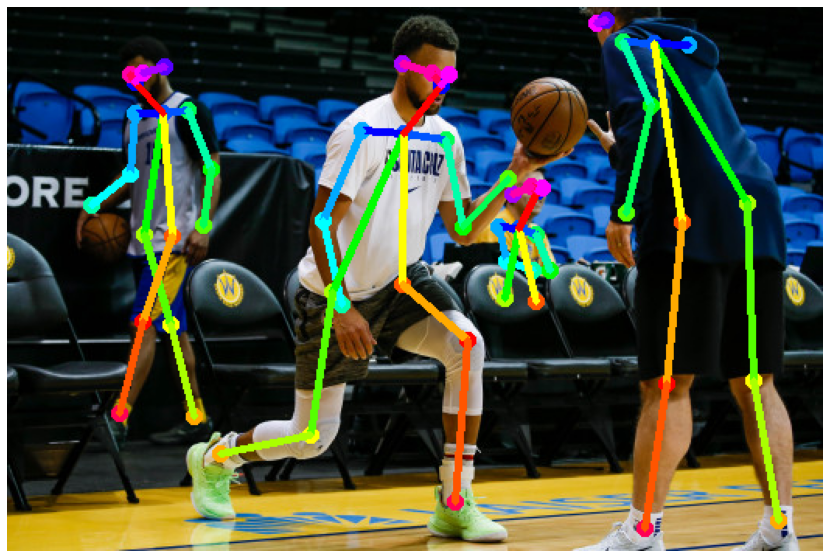

In [ ]:
print("mAP: {} ".format(im_scale))
humans = paf_to_pose_cpp(heatmap, paf, cfg)
        
out = draw_humans(oriImg, humans)
destRGB_2 = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,10))
imgplot = plt.imshow(destRGB_2)
plt.axis('off')
plt.show()

# Processing videos

In [ ]:
#import cv2
from google.colab.patches import cv2_imshow

filename = './dataTpPoseKeraal/ctk/data1/Vid003.mp4'
#You should also do it with the other videos, for example 
# filename = './dataTpPoseKeraal/ctk/data2/Vid015.mp4'
#filename = './dataTpPoseKeraal/ctk/data3/VideoColorCorrect0.mp4'
#filename = './dataTpPoseKeraal/rtk/data4/Vid008.mp4'
#filename = './dataTpPoseKeraal/rtk/data5/Vid021.mp4'
#filename = './dataTpPoseKeraal/rtk/data6/VideoColor_Correct0.mp4'

images =[]
video_capture = cv2.VideoCapture(filename)

#for the output file
# We need to set resolutions. 
# so, convert them from float to integer. 
frame_width = int(video_capture.get(3)) 
frame_height = int(video_capture.get(4)) 
   
size = (frame_width, frame_height) 
   
# Below VideoWriter object will create 
# a frame of above defined The output  
# is stored in 'filename.avi' file. 
result = cv2.VideoWriter('./filename.avi',  
                         cv2.VideoWriter_fourcc(*'MJPG'), 
                         10, size) 

for i in range(20): #only for 10 frames COMMENT OUT FOR THE WHOLE VIDEO TODO
# while video_capture.isOpened(): #for the whole video
        # Capture frame-by-frame
        is_success, oriImg = video_capture.read()
        if not is_success:
            print("Fail")
            break
        
        shape_dst = np.min(oriImg.shape[0:2])

        with torch.no_grad():
            paf, heatmap, imscale = get_outputs(
                oriImg, model, 'rtpose')
                  
        humans = paf_to_pose_cpp(heatmap, paf, cfg)
                
        out = draw_humans(oriImg, humans)

        # Display the resulting frame
        output.clear()
        images.append(out)
        #cv2_imshow(out)
        # Write the frame into the 
        # output file 
        result.write(out) 

        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Quit")
            break

    # When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()
print("End of video")

End of video


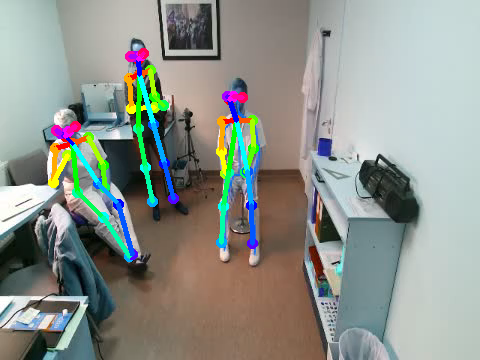

In [ ]:
from IPython.display import Image
from numpngw import write_apng

#imageio.mimsave('a2c.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
write_apng('video.png', images, delay=20)
Image(filename='video.png')

You can read the details of the COCO model skeleton in https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/02_output.md
The list of joints is:
0. Head
1. mShoulder
2. rShoulder
3. rElbow
4. rWrist
5. lShoulder
6. lElbow
7. lWrist
8. rHip
9. rKnee
10. rAnkle
11. lHip
12. lKnee
13. lAnkle

In [ ]:
# Body Model given as a dictionary of the body parts
body_parts={0:"Head",1:"mShoulder",2:"rShoulder",3:"rElbow",4:"rWrist",5:"lShoulder",6:"lElbow",7:"lWrist",8:"rHip",9:"rKnee",10:"rAnkle",11:"lHip",12:"lKnee",13:"lAnkle"}


#Project

For each group, please do 2 projects: project 1 (blur face) and one of the two others; either :


*   Project 2 Classify movements or
*   Project 3 Control a robot





##Blur Face

**Project1 : Write the code to blur the faces of all people to anonymise them**


##### Examples

Below is an example code using opencv to blur an image

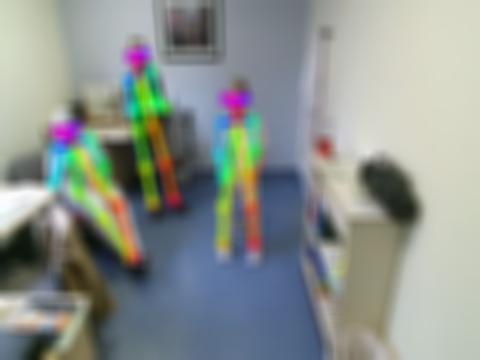

In [ ]:
blurredArray = cv2.GaussianBlur(out, (15, 15), 11) # light blurring
cv2_imshow(blurredArray)


Below is an example code to apply a mask to only blur a circle of center (100,100) and radius 50

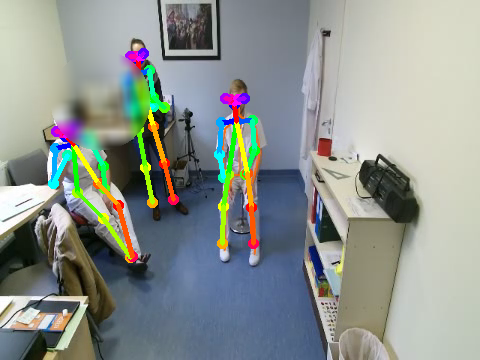

In [ ]:
mask = np.zeros((frame_height, frame_width), dtype=np.uint8)  # mask is only
center =(100,100)
radius = 50
cv2.circle(mask, center, radius, (255, 255, 255), -1)
mask = mask / 255.0
mask = np.expand_dims(mask, axis=-1)
image = (1.0 - mask) * out + mask * blurredArray
image = image.astype(np.uint8)
cv2_imshow(image)


Below is an example code to create a convex hull of 3 points [100,100],[200,100], [200,200] before blurring.

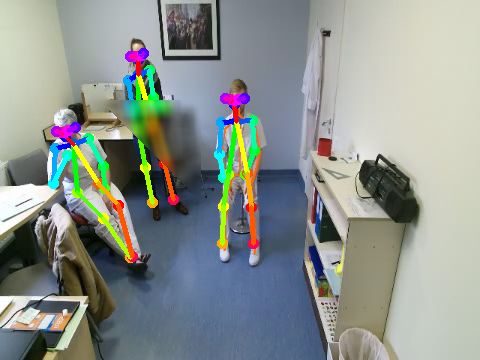

In [ ]:
mask = np.zeros((frame_height, frame_width), dtype=np.uint8)  # mask is only
xy=np.array([[100,100],[200,100], [200,200]]) 
shape = cv2.convexHull(xy)
cv2.drawContours(mask, [shape], -1, 255, -1)
mask = mask / 255.0
mask = np.expand_dims(mask, axis=-1)
image = (1.0 - mask) * out + mask * blurredArray
image = image.astype(np.uint8)
cv2_imshow(image)

--- 
#### Implementation of Project 1

The idea to blur the users faces is to use the squeleton generated from Coco. By using the center of the head (0), and the center of the shoulders (1), a circle can be modelized and use to blur the faces. Its center will be the head and the radius the distance between the middle of the head and the middle of the shoulders.

--- 

In [ ]:
#Project1 : Write the code to blur the faces of all people to anonymise them
#TODO : PLEASE INSERT YOUR CODE HERE AND SAVE THE OUTPUT VIDEO

First, let's test on one image (the first of the video). 

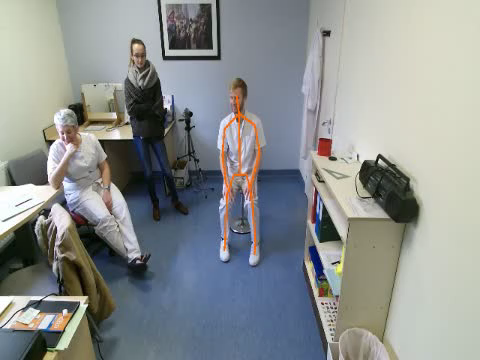

In [ ]:
############ Test on first image of the video ####### 
def getFirstFrame(videofile):
    vidcap = cv2.VideoCapture(videofile)
    success, image = vidcap.read()
    if success:
        return image

image = getFirstFrame(filename)
cv2_imshow(image)

In [ ]:
###### get center : 0, mShoulder : 1 and radius : distance from 0-1 
H = []
for i in range(len(humans)):
  human = humans[i] 
  xy=[]
  for bPart in [0,1]:
      if bPart in human.body_parts:
          x=human.body_parts[bPart].x
          y=human.body_parts[bPart].y
          pos=[x*frame_width,y*frame_height] # position from skeleton in proportion, so * by width and height
          xy.append(pos)
          print("For human {}, pos is {}".format(i,pos))
  xy = np.array(xy)
  H.append(xy)

For human 0, pos is [234.19354838709677, 103.69565217391305]
For human 0, pos is [236.1290322580645, 121.30434782608695]
For human 1, pos is [64.83870967741935, 135.97826086956522]
For human 1, pos is [72.58064516129032, 143.80434782608697]
For human 2, pos is [138.38709677419357, 58.69565217391305]
For human 2, pos is [138.38709677419357, 74.34782608695652]


18 (234, 103)
11 (64, 135)
16 (138, 58)


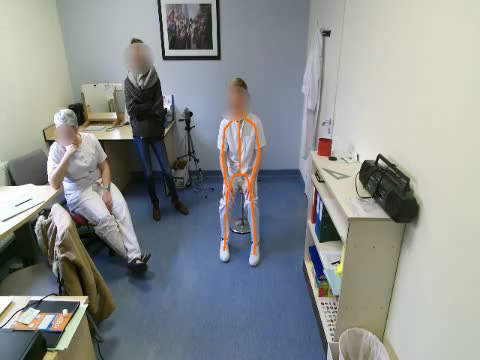

In [ ]:
blurredArray = cv2.GaussianBlur(image, (15, 15), 11) # light blurring

for xy in H:
  xy = xy.astype(int)
  radius = int(np.linalg.norm(xy[0]-xy[1]))
  center = tuple(xy[0])
  print(radius, center)
  mask = np.zeros((frame_height, frame_width), dtype=np.uint8)  

  cv2.circle(mask, center, radius, (255, 255, 255), -1)
  mask = mask / 255.0
  mask = np.expand_dims(mask, axis=-1)
  image = (1.0 - mask) * image + mask * blurredArray
  image = image.astype(np.uint8)
cv2_imshow(image)

We have here blurred all the faces appearing in the image. Then, let's do it for all the images of the video and save it in a video with cv2. 

The final video will be downloaded in the current repository. 

In [ ]:
# filename = './dataTpPoseKeraal/ctk/data1/Vid003.mp4'
# filename = './dataTpPoseKeraal/ctk/data2/Vid015.mp4'
#filename = './dataTpPoseKeraal/ctk/data3/VideoColorCorrect0.mp4'
#filename = './dataTpPoseKeraal/rtk/data4/Vid008.mp4'
filename = './dataTpPoseKeraal/rtk/data5/Vid021.mp4'
# filename = './dataTpPoseKeraal/rtk/data6/VideoColor_Correct0.avi'

images =[]
video_capture = cv2.VideoCapture(filename) # to read the video

frame_width = int(video_capture.get(3)) 
frame_height = int(video_capture.get(4)) 
size = (frame_width, frame_height) 

result = cv2.VideoWriter('./blurred_vid5.avi',  
                         cv2.VideoWriter_fourcc(*'MJPG'), 
                         15.0, size)  # 15 fps in the videos 

# for i in range(20): #only for 10 frames COMMENT OUT FOR THE WHOLE VIDEO TODO
while video_capture.isOpened(): #for the whole video
        # Capture frame-by-frame
        is_success, oriImg = video_capture.read()
        if not is_success:
            print("fail opening")
            break
        
        shape_dst = np.min(oriImg.shape[0:2])

        with torch.no_grad():
            paf, heatmap, imscale = get_outputs(
                oriImg, model, 'rtpose')
                  
        humans = paf_to_pose_cpp(heatmap, paf, cfg)

        # instead of out draw humans, write out of blurred images
        H = []
        # get the positions from humans
        for i in range(len(humans)):
          # print("found {} humans".format(len(humans)))
          human = humans[i] 
          xy=[]
          for bPart in [0,1]:
              if bPart in human.body_parts:
                  x=human.body_parts[bPart].x
                  y=human.body_parts[bPart].y
                  pos=[x*frame_width,y*frame_height]
                  xy.append(pos)
              else :
                print("Did not found a head or shoulder !", humans)
          xy = np.array(xy)
          H.append(xy)

        # blurring all faces
        image = oriImg

        blurredArray = cv2.GaussianBlur(image, (15, 15), 11)
        for xy in H:
          xy = xy.astype(int)
          if len(xy) >= 2 :
            radius = int(np.linalg.norm(xy[0]-xy[1]))
            center = tuple(xy[0])
          elif len(xy) == 0 :
            break
          else : 
            center = tuple(xy[0])
            radius = 0
          mask = np.zeros((frame_height, frame_width), dtype=np.uint8) 

          cv2.circle(mask, center, radius, (255, 255, 255), -1)
          mask = mask / 255.0
          mask = np.expand_dims(mask, axis=-1)
          image = (1.0 - mask) * image + mask * blurredArray
          image = image.astype(np.uint8)

        # output.clear() # commented to see the prints 
        images.append(image)
        result.write(image) 

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything is done, release the capture
video_capture.release()
result.release()
cv2.destroyAllWindows()
print("End of video creation ")

fail opening
End of video creation 


We chose the second project : classification of the movements. 

## Classify the movements
**Project2 : Use one of the representations of movements to model the two exercises and classify them.**
Each exercise has 3 videos. Please try to use 2 of them to train a model, and use the 3rd video for testing.

You can refer to the pytorch tutorial on sequence models in https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html and the documentation on torch.nn on https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [ ]:
#Project2 : Use one of the representations of movements to model the two exercises and classify them.
#TODO: WRITE YOUR CODE HERE

#### Naive approach :

Stack all the images from the videos with the corresponding label for each image. Then after training, we will predict the exercise of the video by predicting for each image an exercice and take the maximum between the two exercices. 

In [ ]:
# Exercice 0 : ctk
prefix = '/content/gdrive/MyDrive/Colab Notebooks/Projet_RL_Robotics/RT-multiperson-pose-pytorch'
label0 = ['/dataTpPoseKeraal/ctk/data1/Vid003.mp4', '/dataTpPoseKeraal/ctk/data2/Vid015.mp4', '/dataTpPoseKeraal/ctk/data3/VideoColor_Correct0.avi']
# Exercice 1 : rtk 
label1 = ['/dataTpPoseKeraal/rtk/data4/Vid008.mp4' , '/dataTpPoseKeraal/rtk/data5/Vid021.mp4' , '/dataTpPoseKeraal/rtk/data6/VideoColor_Correct0.avi' ]

for i in range(3):
  label0[i] = prefix + label0[i]
  label1[i] = prefix + label1[i]

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout, Flatten, Dense, LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
data = []
labels = []

# label 0
for imagePath in label0[:-1]: # data is all except the last
  video_capture = cv2.VideoCapture(imagePath)
  while video_capture.isOpened():
    label = 'ctk'
    success, image = video_capture.read()
    if not success:
      print("Failed to open ", imagePath)
      break
          
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (frame_width, frame_height))

    data.append(image)
    labels.append(label)

# label 1
for imagePath in label1[:-1]:
  video_capture = cv2.VideoCapture(imagePath)
  while video_capture.isOpened():
    label = 'rtk'
    success, image = video_capture.read()
    if not success:
      print("Failed to open ", imagePath)
      break
          
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (frame_width, frame_height))

    data.append(image)
    labels.append(label)

Failed to open  /content/gdrive/MyDrive/Colab Notebooks/Projet_RL_Robotics/RT-multiperson-pose-pytorch/dataTpPoseKeraal/ctk/data1/Vid003.mp4
Failed to open  /content/gdrive/MyDrive/Colab Notebooks/Projet_RL_Robotics/RT-multiperson-pose-pytorch/dataTpPoseKeraal/ctk/data2/Vid015.mp4
Failed to open  /content/gdrive/MyDrive/Colab Notebooks/Projet_RL_Robotics/RT-multiperson-pose-pytorch/dataTpPoseKeraal/rtk/data4/Vid008.mp4
Failed to open  /content/gdrive/MyDrive/Colab Notebooks/Projet_RL_Robotics/RT-multiperson-pose-pytorch/dataTpPoseKeraal/rtk/data5/Vid021.mp4


In [ ]:
print(len(data), len(labels))

1737 1737


We encode the two exercices with a one hot encoding. Here, [1,0] is the first movement (ctk directory), while [0,1] is the other one. Then, we use 80% of the data to train the model. 

Also, we use the stratify argument to get the same proportion of each movement in the datasets (in our case around 50 % : 2 videos of each exercise). 

In [ ]:
data = np.array(data)
labels = np.array(labels)

# ohe on the labels ctk or rtk
labels = np.array([[1,0] if l == 'ctk' else [0,1] for l in labels])

print(labels)

# 80% to train, the other to test 
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.2, stratify=labels, random_state=42) 

[[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]


#### First model with ResNet50 as base model
We used the ResNet50 as a base Model. However we are not sure yet if its really relevent for our case but it can be a good base Model for classification in general. 

In [ ]:
# resnet 50 with image net network 
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(frame_height, frame_width, 3)))


# The core of our model 
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.6)(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(2, activation="softmax")(headModel) # two categories and classification (dense with 2 outputs and softmax)

# create our model 
model = Model(inputs=baseModel.input, outputs=headModel)

# the layers of the base model should not be trained (are already from ResNet)
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# Parameters 
epochs = 3
lr = 1e-4
momentum = 0.9
decay = 1e-4 /epochs

In [ ]:
# SGD optimizer 
opt = SGD(lr=lr, momentum=momentum, decay= decay )

# compilation of the model
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

# train
H = model.fit(x = trainX, y = trainY, steps_per_epoch=len(trainX) // 32, validation_data= (testX, testY),	epochs= epochs)

Epoch 1/3
43/43 [==============================] - 24s 491ms/step - loss: 0.8377 - accuracy: 0.6229 - val_loss: 0.2356 - val_accuracy: 1.0000
Epoch 2/3
43/43 [==============================] - 21s 498ms/step - loss: 0.3749 - accuracy: 0.9125 - val_loss: 0.1180 - val_accuracy: 1.0000
Epoch 3/3
43/43 [==============================] - 20s 478ms/step - loss: 0.2280 - accuracy: 0.9742 - val_loss: 0.0651 - val_accuracy: 1.0000


### Plots

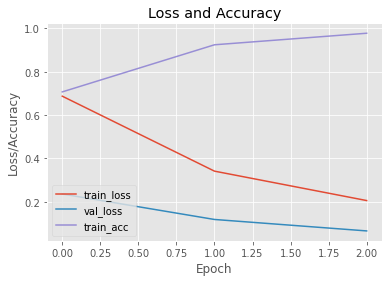

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")

plt.title("Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

Now, time to predict on the last two videos. We stack the images of each video and predict for each one the corresponding exercise. Then, we average the value to predict the exercise of the video. 

In [ ]:
# Predict on the two last videos 
test0 = []
test1 = []

for imagePath in label0[-1:]:
  video_capture = cv2.VideoCapture(imagePath)
  while video_capture.isOpened():
    success, image = video_capture.read()
    if not success:
      print("Failed to open ", imagePath)
      break
          
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (frame_width, frame_height))

    # update the data and labels lists, respectively
    test0.append(image)

for imagePath in label1[-1:]:
  video_capture = cv2.VideoCapture(imagePath)
  while video_capture.isOpened():
    success, image = video_capture.read()
    if not success:
      print("Failed to open ", imagePath)
      break
          
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (frame_width, frame_height))

    # update the data and labels lists, respectively
    test1.append(image)

test0 = np.array(test0)
test1 = np.array(test1)

Failed to open  /content/gdrive/MyDrive/Colab Notebooks/Projet_RL_Robotics/RT-multiperson-pose-pytorch/dataTpPoseKeraal/ctk/data3/VideoColor_Correct0.avi
Failed to open  /content/gdrive/MyDrive/Colab Notebooks/Projet_RL_Robotics/RT-multiperson-pose-pytorch/dataTpPoseKeraal/rtk/data6/VideoColor_Correct0.avi


In [ ]:
print(len(test0), len(test1))

196 194


In [ ]:
predictions = model.predict(x=test0.astype("float32"), batch_size=32)
print("Average predictions on first video : ", predictions.mean(axis=0))
print("Will be labelled", np.argmax(predictions.mean(axis=0)))

Average predictions on first video :  [0.6194932  0.38050702]
Will be labelled 0


In [ ]:
predictions = model.predict(x=test1.astype("float32"), batch_size=32)
print("Average predictions on second video : ", predictions.mean(axis=0))
print("Will be labelled", np.argmax(predictions.mean(axis=0)))

Average predictions on second video :  [0.4360619 0.5639381]
Will be labelled 1


##### Conclusion with ResNet50 and DL on images
----

With this method using ResNet50, we were able to correctly classify the two video exercices. 

The model is composed of an Average Pooling layer (5*5) and two Dense-Relu layers respectively 1024 and 512 dimensions. We also added Dropouts layers to avoid overfitting with 0.6 and 0.4 proportion. 

After 3 epochs, we reached 97% accuracy. And then, on prediction, respectively 62% and 56% on the classification. 


### Video processing to use LSTMs
----
Using LSTM and CNN. We will need batches of the video to learn the pattern of the movements and the temporal depedencies. However to be done, we cannot use simple LSTM on videos or images. 

We will try to use the following library : https://pypi.org/project/keras-video-generators/ to create sorts of data loaders from videos. 


In [ ]:
!pip install keras-video-generators

  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp37-none-any.whl size=12884 sha256=7dde3004a22c7265dff1d0eb277540cbffc56c332c52db0b0dfe4bbfe02406ea
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


In [ ]:
# import the frames generator
import keras
from keras_video import VideoFrameGenerator, SlidingFrameGenerator

In [ ]:
from keras.layers import ConvLSTM2D, Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import Activation
from keras.layers import TimeDistributed, LSTM, Dense, Dropout

In [ ]:
# parameter of the lstm
sequence_length = 6

In [ ]:
# global pattern : will allow to create batches from the datasets and generate the corresponding classes
# Note here the videos are directly copied in the ctk/ and rtk/ directories (not in datax/ ones)
glob_pattern='/content/gdrive/MyDrive/Colab Notebooks/Projet_RL_Robotics/RT-multiperson-pose-pytorch/dataTpPoseKeraal/{classname}/*.*'

# define the two classes 
classes = ['ctk', 'rtk']
batch_size = 2

train = VideoFrameGenerator(
    glob_pattern=glob_pattern,
    nb_frames= sequence_length,
    split_val = 0.1, # small value so no video in our case
    split_test=0.4,  # to be able to get one video from each 
    shuffle=True,
    batch_size= batch_size,
    target_shape= (frame_width, frame_height),
    nb_channel= 3,
    transformation= None, # no data augmentation 
    use_frame_cache= False) # can activate if large RAM

# train = SlidingFrameGenerator(
#     glob_pattern=glob_pattern,
#     nb_frames= sequence_length,
#     split_val = 0.1, # small value so no video in our case
#     split_test=0.4,  # to be able to get one video from each 
#     shuffle=True,
#     batch_size= batch_size,
#     target_shape= (frame_width, frame_height),
#     nb_channel= 3,
#     transformation= None, # no data augmentation 
#     use_frame_cache= False, # can activate if large RAM
#     sequence_time = 1) 


class ctk, validation count: 0, test count: 1, train count: 2
class rtk, validation count: 0, test count: 1, train count: 2
Total data: 2 classes for 4 files for train


In [ ]:
valid = train.get_validation_generator() # check if no validation in our case

Total data: 2 classes for 0 files for validation


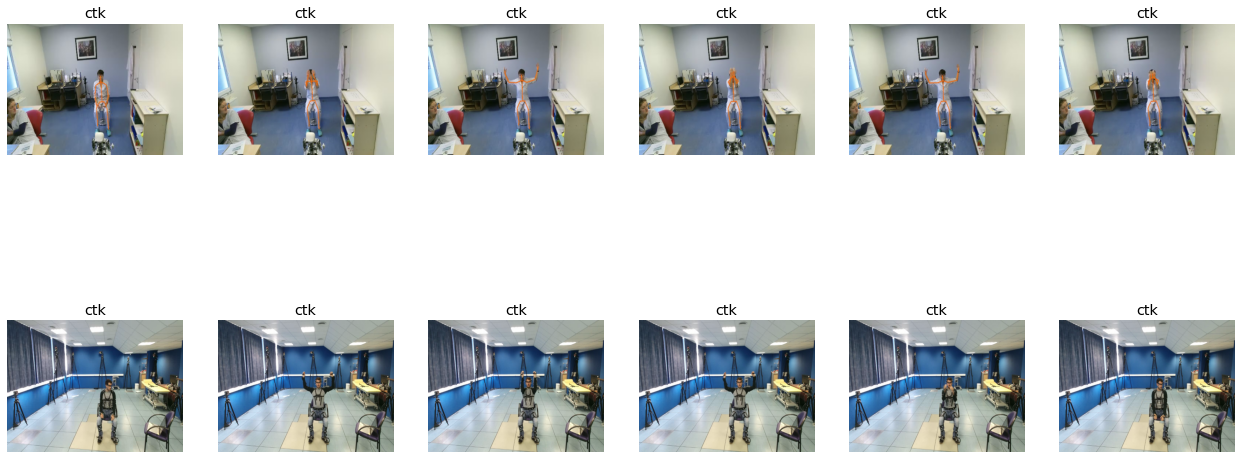

In [ ]:
import keras_video.utils
keras_video.utils.show_sample(train)

In [ ]:
# Build a convolutional network as a base 
# conv layer / Max Pool 

def build_convnet(shape = (sequence_length, frame_height, frame_width, 3) ):
  momentum = .9
  model = Sequential()
  model.add(Conv2D(64, (5,5), input_shape=shape,
      padding='same', activation='relu'))
  model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=momentum))

  model.add(MaxPool2D())

  model.add(Conv2D(128, (5,5), padding='same', activation='relu'))
  model.add(Conv2D(128, (5,5), padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=momentum))

  model.add(MaxPool2D())

  model.add(Conv2D(256, (5,5), padding='same', activation='relu'))
  model.add(Conv2D(256, (5,5), padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=momentum))

  model.add(MaxPool2D())

  model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
  model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=momentum))

  # flatten
  model.add(GlobalMaxPool2D())
  return model

In [ ]:
def action_model(shape=(sequence_length, frame_height, frame_width, 3), out=2):

    convnet = build_convnet(shape[1:]) # use the previous convnet
    
    model = Sequential()

    # Time Distributed because of LSTM nature
    model.add(TimeDistributed(convnet, input_shape=shape))
    model.add(LSTM(64)) 

    # Dense layers (like in the first part)
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.6))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(out, activation='softmax'))
    return model

In [ ]:
shape = (sequence_length, frame_width, frame_height, 3) 

model = action_model(shape, len(classes))
optimizer = Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy', # categorical crossentropy for our classification problem
    metrics=['acc']
)

In [ ]:
epochs = 10
# create a checkpoints directory to store models callbacks

callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{loss:.2f}.hdf5',
        verbose=1),
]
hist = model.fit_generator(
    train,
    validation_data=valid,
    verbose=1,
    epochs= epochs,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
2/2 [==============================] - 2s 850ms/step - loss: 0.7044 - acc: 0.5000

Epoch 00001: saving model to chkp/weights.01-0.70.hdf5
Epoch 2/10
2/2 [==============================] - 2s 845ms/step - loss: 0.6906 - acc: 0.2500

Epoch 00002: saving model to chkp/weights.02-0.69.hdf5
Epoch 3/10
2/2 [==============================] - 2s 855ms/step - loss: 0.5515 - acc: 0.7500

Epoch 00003: saving model to chkp/weights.03-0.55.hdf5
Epoch 4/10
2/2 [==============================] - 2s 854ms/step - loss: 0.6956 - acc: 0.5000

Epoch 00004: saving model to chkp/weights.04-0.70.hdf5
Epoch 5/10
2/2 [==============================] - 2s 848ms/step - loss: 0.6298 - acc: 0.7500

Epoch 00005: saving model to chkp/weights.05-0.63.hdf5
Epoch 6/10
2/2 [==============================] - 2s 854ms/step - loss: 0.7873 - acc: 0.2500

Epoch 00006: saving model to chkp/weights.06-0.79.hdf5
Epoch 7/10
2/2 [==============================] - 2s 852ms/step - loss: 0.5611 - acc: 0.7500

Epoch 00007:

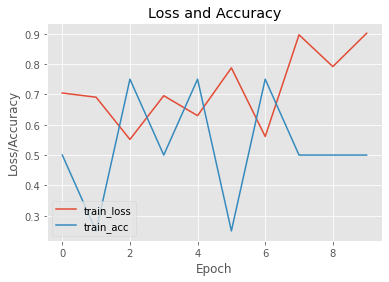

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), hist.history["acc"], label="train_acc")

plt.title("Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
# prediction on test videos
glob_pattern='/content/gdrive/MyDrive/Colab Notebooks/Projet_RL_Robotics/RT-multiperson-pose-pytorch/dataTpPoseKeraal/{classname}/*.*'

gen = VideoFrameGenerator(
    glob_pattern=glob_pattern,
    nb_frames= sequence_length,
    split_val = 0.1,
    split_test=0.4, 
    shuffle=True,
    batch_size= batch_size,
    target_shape= (frame_width, frame_height),
    nb_channel= 3,
    transformation= None,
    use_frame_cache= False) # can activate if large RAM

test_gen = gen.get_test_generator()

class ctk, validation count: 0, test count: 1, train count: 2
class rtk, validation count: 0, test count: 1, train count: 2
Total data: 2 classes for 4 files for train
Total data: 2 classes for 2 files for test


In [ ]:
test_gen = train.get_test_generator()

Total data: 2 classes for 2 files for test


In [ ]:
res = model.predict(test_gen)
print(res)

[[0.5753287  0.4246713 ]
 [0.57670146 0.4232986 ]]


In [ ]:
results = model.evaluate(test_gen , verbose=2)

1/1 - 1s - loss: 0.7062 - acc: 0.5000


In [ ]:
for i in range(len(res)):
  print("Video {} is labelled {}".format(i, np.argmax(res[i])))

Video 0 is labelled 0
Video 1 is labelled 0


### Conclusion 
----

With this method, we obtained an accuracy of 50%, which means that only a video out of the two was rightly labelled.
Also, when displaying the probabilities, it is almost 57% for each category, which shows that it is quite hard to have a strong prediction and here it labels the same movement (0) for the two test videos. 


Here, the LSTM method didn't allow us to have better results than the model based on Resnet50. Maybe with more data and different networks, better results could be obtained, however with the first method we were still able to get a first good result of correct classification. 